In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.5 MB/s eta 0:00:00


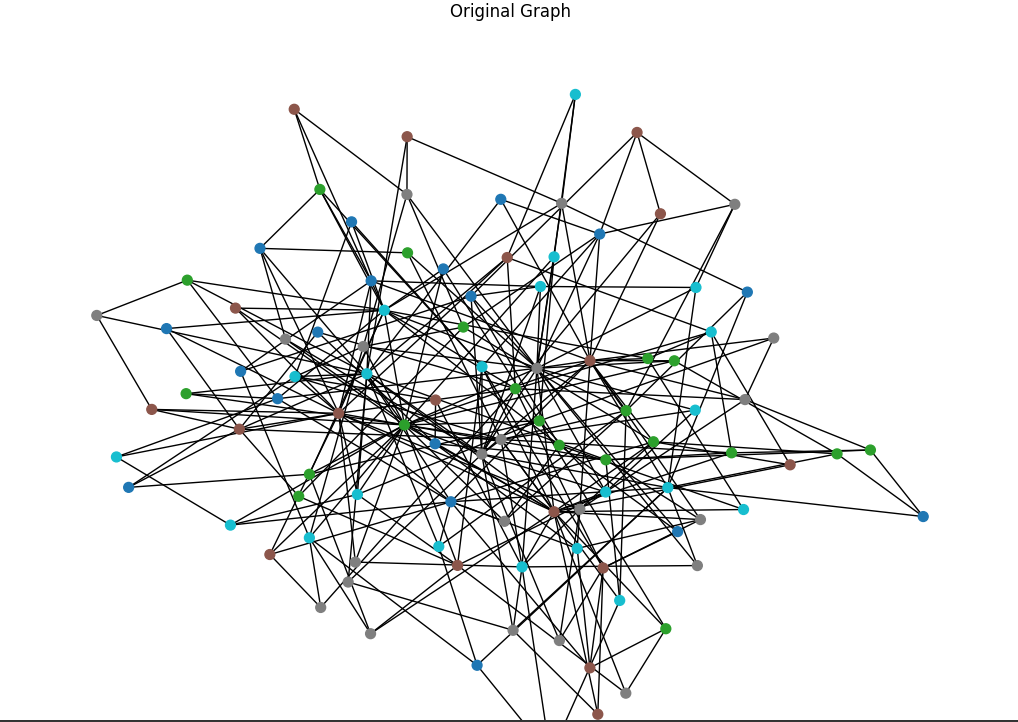

Epoch 000, Loss: 10949670993920.0000, Val Acc: 0.2000
Epoch 010, Loss: 11577439813632.0000, Val Acc: 0.2667
Epoch 020, Loss: 19711146328064.0000, Val Acc: 0.2667
Epoch 030, Loss: 21869918945280.0000, Val Acc: 0.2667
Epoch 040, Loss: 19234526593024.0000, Val Acc: 0.2667
Epoch 050, Loss: 7762673664000.0000, Val Acc: 0.2667
Epoch 060, Loss: 18183807303680.0000, Val Acc: 0.1333
Epoch 070, Loss: 15291025195008.0000, Val Acc: 0.1333
Epoch 080, Loss: 25538213183488.0000, Val Acc: 0.2000
Epoch 090, Loss: 13954892955648.0000, Val Acc: 0.2667


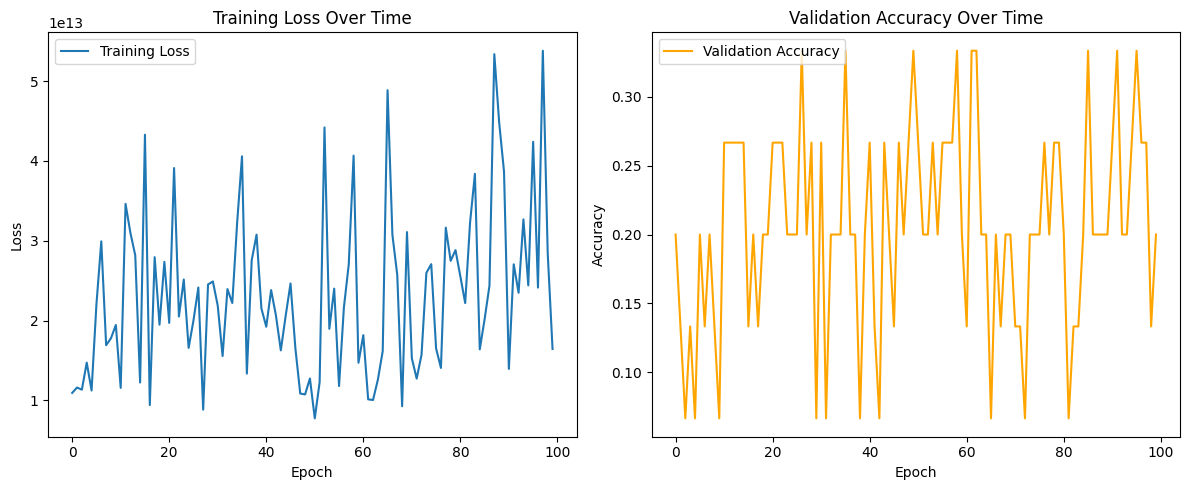

Test Accuracy: 0.0667


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from sklearn.metrics import accuracy_score
from torch_geometric.utils import from_networkx

class GraphWavelets:
    def __init__(self, G):
        self.G = G
        self.N = G.number_of_nodes()
        self.compute_wavelets()

    def compute_wavelets(self):
        # Матрица Лапласа
        L = nx.normalized_laplacian_matrix(self.G).toarray()

        # Собственные значения и векторы
        eigvals, eigvecs = eigh(L)

        # Параметры вейвлета
        s = 1.0  # Масштаб
        h = lambda x: x * np.exp(-x)  # Мексиканская шляпа

        # Вычисление вейвлетов
        psi = np.zeros((self.N, self.N))
        for i in range(self.N):
            for j in range(self.N):
                psi[i, j] = np.sum(eigvecs[i, :] * h(s * eigvals) * eigvecs[j, :])

        self.psi = torch.FloatTensor(psi)
        self.psi_inv = torch.FloatTensor(np.linalg.pinv(psi))

class GWNNLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GWNNLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Веса для фильтрации в вейвлет-домене
        self.weight = nn.Parameter(torch.FloatTensor(input_dim, output_dim))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x, psi, psi_inv):
        # Преобразование в вейвлет-домен
        x_wavelet = torch.matmul(psi, x)

        # Применение весов в вейвлет-домене
        x_filtered = torch.matmul(x_wavelet, self.weight)

        # Обратное преобразование
        x_out = torch.matmul(psi_inv, x_filtered)

        return F.relu(x_out)

class GWNN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GWNN, self).__init__()
        self.layer1 = GWNNLayer(num_features, hidden_dim)
        self.layer2 = GWNNLayer(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, psi, psi_inv):
        x = self.layer1(x, psi, psi_inv)
        x = self.layer2(x, psi, psi_inv)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

def visualize_graph(G, labels, title="Graph Structure"):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color=labels, cmap=plt.cm.tab10,
            node_size=50, with_labels=False)
    plt.title(title)
    plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.tab10),
                 label="Node Class")
    plt.show()

def plot_training(epochs, train_losses, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    # Параметры
    num_nodes = 100
    num_features = 32
    hidden_dim = 64
    num_classes = 5
    epochs = 100
    lr = 0.01

    # Генерация данных
    G = nx.barabasi_albert_graph(num_nodes, 3)
    features = np.random.randn(num_nodes, num_features)
    labels = np.random.randint(0, num_classes, num_nodes)

    # Визуализация исходного графа
    #visualize_graph(G, labels, "Original Graph")

    # Вычисление вейвлетов
    wavelets = GraphWavelets(G)
    psi = wavelets.psi
    psi_inv = wavelets.psi_inv

    # Преобразование данных
    features = torch.FloatTensor(features)
    labels = torch.LongTensor(labels)

    # Разделение данных
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    indices = torch.randperm(num_nodes)
    train_mask[indices[:int(0.7*num_nodes)]] = True
    val_mask[indices[int(0.7*num_nodes):int(0.85*num_nodes)]] = True
    test_mask[indices[int(0.85*num_nodes):]] = True

    # Модель и оптимизатор
    model = GWNN(num_features, hidden_dim, num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.NLLLoss()

    # Обучение
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        out = model(features, psi, psi_inv)
        loss = criterion(out[train_mask], labels[train_mask])
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Валидация
        model.eval()
        with torch.no_grad():
            pred = model(features, psi, psi_inv).argmax(dim=1)
            val_acc = accuracy_score(labels[val_mask].numpy(), pred[val_mask].numpy())
            val_accuracies.append(val_acc)

        if epoch % 10 == 0:
            print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}')

    # Визуализация обучения
    plot_training(epochs, train_losses, val_accuracies)

    # Тестирование
    model.eval()
    with torch.no_grad():
        pred = model(features, psi, psi_inv).argmax(dim=1)
        test_acc = accuracy_score(labels[test_mask].numpy(), pred[test_mask].numpy())
        print(f'Test Accuracy: {test_acc:.4f}')

    # Визуализация предсказаний
  #  visualize_graph(G, pred.numpy(), "Predicted Classes")

if __name__ == '__main__':
    main()